## CHAPTER 3 분류
## 3.1 MNIST
- 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋

In [1]:
import re
import argparse
import csv
from collections import Counter
from sklearn import datasets
import sklearn
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')

- 데이터셋을 설명하는 DESCR키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
- 레이블 배열을 담고 있는 target키

In [3]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape # 70,000개의 이미지가 있고 이미지에는 784개의 특성이 있다.

(70000, 784)

In [6]:
y.shape # 0 ~ 9 까지의 숫자

(70000,)

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

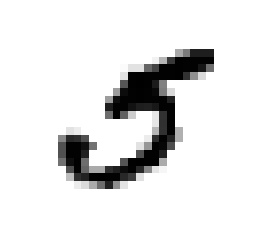

In [8]:
some_digit = X[36000] # 36000번째 데이터
some_digit_image = some_digit.reshape(28,28) # 784개의 특성 -> 28X28 이미지로 변환

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
        interpolation = 'nearest') # 36000번째 데이터 시각화
plt.axis('off')
plt.show()

In [9]:
y[36000] # 해당 레이블 확인

5.0

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]
# train data 와 test data를 분류 
# train 0 ~ 59,999개 test 60,000 ~ 69,999개

- 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야한다.

In [11]:
import numpy as np

In [12]:
shuffle_index = np.random.permutation(60000)
# 60000개의 데이터를 모든 조합에 따라 셔플
print(shuffle_index) # index가 랜덤하게 셔플

[40434 58911 26656 ... 30136 28800 21766]


- 훈련 세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 만든다.
> - 하나의 폴드라도 특정 숫자가 누락되면 안 된다.
- 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다.
> - 주식가격이나 날씨 예보 같은 시계열 데이터를 다룰 때는 섞지 않는 것이 좋다.
> - SGD가 샘플을 섞어야 하는 대표적인 경우다.

In [13]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
# 인덱스 정보에 따라 데이터를 매핑

## 3.2 이진 분류기 훈련
- 문제를 단순화해서 하나의 숫자, 예를 들면 숫자 5만 식별한다고 가정하면
> - '5'와 '5아님' 두 개의 클래스를 구분할 수 있는 이진 분류기(binary classifier)의 한 예이다.
- 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD) 분류기로 훈련 시킨다.
> - 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있다.
> - SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문이다. 따라서 SGD가 온라인 학습에 잘 들어 맞는다.

![test](./img/배치.png)

![test](./img/단점.png)

In [14]:
y_train_5 = (y_train == 5) # y_train 5 인 경우 True 아니면 False
y_test_5 = (y_test == 5) 

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
# max_iter: 계산을 5번 반복
sgd_clf.fit(X_train,y_train_5)
# 훈련데이터 전체를 학습시키고 y_train_5는 숫자 5의 데이터를 학습시킨다.

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([some_digit]) 
# 36000번째 데이터를 모델에서는 5로 예측

array([ True])

## 3.3 성능 측정
- 분류기 평가는 회귀 모델보다 훨씬 어렵다.

## 3.3.1 교차 검증을 사용한 정확도 측정
- cross_val_score() 함수로 폴드가 3개인 K-겹 교차 검증을 사용해 SGDClassifier 모델을 평가
> - 훈련 세트를 아래 예제에선 3개로 나누고, 각 폴드에 대해 예측을 만들고 평가하기위해 나머지 폴드로 훈련시킨 모델을 사용

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy') 
# SGD모델 / 훈련데이터 / 3개의 폴드 생성 / 정확도 출력)

array([0.94645, 0.9566 , 0.9694 ])

- 모든 교차 검증 폴드에 대한 정확도(정확한 예측 비율)가 95% 이상이다.

In [22]:
from sklearn.base import BaseEstimator

In [24]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None): # X를 인수로 받고 y 변수 초기화
        pass
    def predict(self,X): # 입력받은 데이터의 크기만큼 0행렬 생성
        return np.zeros((len(X),1), dtype=bool)

- 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기 생성

In [25]:
never_5_clf = Never5Classifier() # Never5Classifier 분류기 생성
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.90975, 0.9121 , 0.9071 ])

- 정확도가 90%이상 나왔다.
> - 이유는 이미지의 10%정도만 숫자 5이기 때문에 무조건 '5아님'으로 예측하면 정확히 맞출 확률이 90%이다.
> - 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 불균형한 데이터셋을 다룰때 (즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇다.

## 3.3.2 오차행렬
- 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬(confusion matrix)을 조사하는 것이다.
> - 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.
- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 된다.
> - 대신 cross_val_prediction()함수를 사용한다.

In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

- cross_val_predict은 같은 K-겹 교차검증을 수행하지만 평가 점수가 아닌 예측 값을 반환한다.

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_train_5,y_train_pred)

array([[52874,  1705],
       [  846,  4575]], dtype=int64)

- 오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.
- 52874은 실제 클래스도 음성 예측 클래스도 음수로 진짜음성 (True negative)
- 1705은 실제 클래스는 음성 예측 클래스는 양수인 거짓양성 (False positive)
- 846은 실제 클래스는 양성 예측 클래스는 음성인 거짓음성 (False negative)
- 4575은 실제 클래스는 양성 예측 클래스도 양성인 진짜 양성 (True positive)

![test](./img/정밀도.png)

- 정밀도(precision)를 통해 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만, 이는 분류기가 다른 모든 양성 샘플을 무시하기 떄문에 그리 유용하지않다.
- 정밀도는 재현율(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.
> - 재현율(recall)은 분류기가 정확하게 감지한 양성 샘플의 비율로, 민감도(sensitivity) 또는 진짜 양성 비율(true positive)라고 한다.

![test](./img/오차행렬.png)

## 3.3.3 정밀도와 재현율
- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공

In [30]:
from sklearn.metrics import precision_score, recall_score

In [31]:
precision_score(y_train_5,y_train_pred) # precisison

0.7285031847133758

In [32]:
recall_score(y_train_5,y_train_pred) # recall

0.843940232429441

- 앞에서 본 정확도를 지표로 했을 때 보다 낮은 결과를 볼 수 있다.
- 5로 판별된 이미지 중 에서 72%만 정확하고 전체 숫자 5에선 84%만 감지했다.
-------------
- 정밀도와 재현율을 F1 점수라고 하는 하나의 숫자로 만들면 편리할 때가 많다.
> - 특히 두 분류기를 비교할 때 효과적
> - F1점수는 정밀도와 재현율의 조화 평균 이다.
- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.
> - 그렇다고 이게 항상 바람직한 것은 아니다 상황에 따라 정밀도가 중요할 수 도 있고 재현율이 중요할 수 도 있다.
>> - 예를들어 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정할때 재현은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도 안전한 것들만 노출시키는 분류기를 선호할 것이다.
>> - 다른 예로, 감시 카메라를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정할때 분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지도 모른다.
- 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지이다. 이를 정밀도/재현율 트레이드오프라 한다.

![test](./img/F1.png)

In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(y_train_5, y_train_pred)

0.7819844457738654

## 3.3.4 정밀도/재현율 트레이드오프
- SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 트레이드오프를 이해해보자
- 이 분류기는 결정 함수(decision function)를 사용하여 각 샘플의 점수를 계산한다.
- 이 점수가 임곗값 보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다.

![test](./img/트레이드오프.png)

- 결정 임곗값이 가운데 화살표라 가정하면 임곗값 오른쪽에 4개의 진짜 양성과 하나의 거짓 양성이 있다. 
> - 따라서 정밀도는 80%(4/5) 재현율 67%(4/6)이다. 
- 만약 오른쪽 화살표가 임곗값이라 가정하면
> - 정밀도는 100%(3/3) 재현율 50%(3/6)이다.
- 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 할 수 있다.

In [35]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores # 결정함수를 반환

array([203275.96605936])

In [36]:
threshold = 0 # 임곗값
y_some_digit_pred = (y_scores > threshold) # bool 자료형으로 반환
y_some_digit_pred

array([ True])

적절한 임계값을 구하기 위해 먼저 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구한다.
> - 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환하도록 지정

In [37]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [38]:
y_scores

array([-1268764.68083072,  -733528.23686833,  -396218.10099701, ...,
        -232154.65830545,  -846943.04033719,  -202270.97729212])

In [39]:
from sklearn.metrics import precision_recall_curve
# precision_recall_curve를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율을 계산 할 수 있다.

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)
# 정밀도, 재현율, 임계값에 대한 정보를 보관

In [43]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds): # 3개의 인수를 받는다.
    plt.plot(thresholds,precisions[:-1],'b--',label='precision') # x축: 임계값, y축: 정밀도
    plt.plot(thresholds,recalls[:-1],'g-',label='recall') # x축: 임계값, y축: 재현율
    plt.xlabel('thresholds') 
    plt.legend(loc='center left') 
    plt.ylim([0,1])

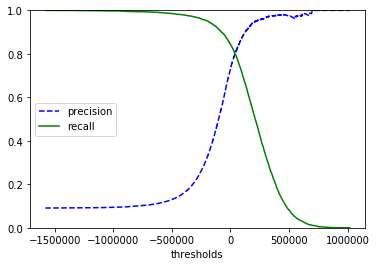

In [44]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

- 정밀도 곡선이 재현율 곡선보다 울퉁불퉁한 이유
> - 이는 임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문이다. (일반적으로는 높아져야한다.)
> - 상황에 따라 정밀도가 올라가면서 중간에 잠깐 내려갔다 올라가는 현상이 반복됨
> - 반면 재현율은 임계값이 내려감에 따라 줄들 수 밖에 없어 부드러운 곡선이 된다.

![test](./img/정재.png)
- 재현율이 80% 근처에서 정밀도가 급격하게 줄어들기 시작합니다. 이 하강점 직전의 정밀도/재현율 트레이드오프로 선택하는 것이 좋다. 예를들어 재현율이 60%정도인 지점이다
> - 물론 이런 선택은 프로젝트에 따라 달라진다.
> - average_precision_score() 함수를 사용하면 정밀도/재현율 곡선의 아래 면적을 구할 수 있어서 서로 다른 두 모델을 비교하는 데 도움이 된다.

In [45]:
y_train_pred_90 = (y_scores > 70000) # 정밀도를 90%를 달성하는 것이 목표라고 가정해보면

In [47]:
precision_score(y_train_5,y_train_pred_90)

0.8395590936925903

In [48]:
recall_score(y_train_5,y_train_pred_90)

0.758716104039845

- 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다.
> - 누군가 99% 정밀도를 달성하자 라고 말하면 반드시 재현율 얼마에서? 라고 물어봐야 한다.

## 3.3.5 ROC 곡선
- 수신기 조작 특성(receiver operating characteristic) ROC 곡선도 이진 분류에서 널리 사용하는 도구이다.
- ROC 곡선은 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율의 다른 이름)의 곡선이다.
> - FPR이란 양성으로 잘못 분류된 음성 샘플의 비율이다
> - 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율 (TNR)을 뺀 값이다.
>> - TNR을 특이도(spceificity)라고도 한다. 그러므로 ROC 곡선은 민감도(재현율)에 대한 1-특이도이다.

![test](./img/roc.png)

- ROC 곡선을 그리려면 먼저 roc_curve()함수를 사용해 여러 임계값에서 TPR과 FPR을 계산해야 한다.

In [50]:
from sklearn.metrics import roc_curve

In [51]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores) # TPR, FPR, 임계값 계산

In [57]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label) # x축:FPR, y축:TPR, linewidth:선 두께
    plt.plot([0,1],[0,1],'k--') # 가운데 수직선 생성
    plt.axis([0,1,0,1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

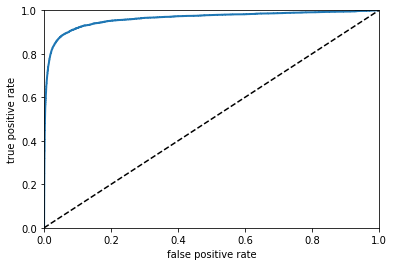

In [58]:
plot_roc_curve(fpr,tpr)
plt.show()

- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다. 
- 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻한다.
- 좋은 분류기는 이 점선으로부터 최대한 멀리 떨어져 있어야 합니다.
----------
- 곡선 아래의 면적(area under the curve)AUC을 측정하면 분류기들을 비교할 수 있다.
- 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5 이다.
> - 랜덤 분류기는 훈련 데이터의 클래스 비율을 따라 무작위로 예측하는 것을 말한다.
> - 이렇게 되면 오차 행렬의 실제 클래스가 비슷한 비율의 예측 클래스로 나뉘어 FPR과 TPR 값이 비슷해진다.
> - 결국 y = x에 가깝게 되어 AUC면적이 0.5가 됩니다.

In [59]:
from sklearn.metrics import roc_auc_score # AUC를 계산하는 함수

In [60]:
roc_auc_score(y_train_5,y_scores)

0.9623097069237116

- ROC 곡선이 정밀도/재현율(PR) 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있다.
- 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용한다.
> - 예를들어 조금 전의 ROC 곡선의 AUC점수를 보면 매우 좋은 분류기라고 생각할 수 있지만 이는 음성에 비해 양성의 크기가 적기 때문이다. 이와는 다르게 PR곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여 줍니다.

In [61]:
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [62]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method = 'predict_proba')

- 랜덤 포레스트에는 decision_function() 메서드가 없지만 predict_proba() 메서드가 있다.
> - 사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있다.
- predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담을 배열을 반환한다
> - 예를들어 어떤 이미지가 5일 확률 70%

In [63]:
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.9, 0.1]])

In [64]:
y_scores_forest = y_probas_forest[:,1] # 두번째 열 전체 '5'인 경우 양성클래스에 대한 확률
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5,y_scores_forest)

- 하지만 ROC 곡선을 그리려면 확률이 아니라 점수가 필요하다. 간단한 해결방법은 양성 클래스의 확률을 점수로 사용하는 것이다.

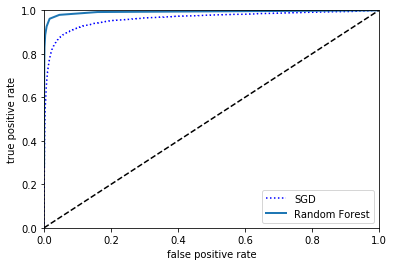

In [66]:
plt.plot(fpr,tpr,'b:',label='SGD') # 점선 
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest') 
plt.legend(loc='lower right')
plt.show()

- 위 그림에서 볼 수 있듯이 랜덤포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGD보다 훨씬 좋아보인다.
- 실제로 AUC점수도 훨씬 높다.

In [67]:
roc_auc_score(y_train_5,y_scores_forest)

0.9927107500288662

## 3.4 다중분류
- 다중 분류기는 둘 이상의 클래스를 구별할 수 있다.
- OvA 전략 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
- OvO 각 숫자의 조합마다 이진 분류기를 훈련시킨다.  ex) 0/1분류 0/2분류 1/2분류
> - 조합의 공식은 nCr이다. 
> - 즉 OvO 전략은 이미지를 한장 분류하려면 45개의 분류기 모두를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택
>> - 서포트 벡터 머신같은 일부 알고리즘은 훈련세트의 크기에 민감해서 큰 훈련 세트에서 몇개의 분류기를 훈련시키는 것보다 작은 훈련세트에서 많은 분류기를 훈련시키는 쪽이 빠르다.
>> - 대부분의 이진 분류 알고리즘은 OvA를 선호한다.

In [68]:
sgd_clf.fit(X_train,y_train) # y_train  0 ~ 9 까지의 숫자 훈련

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [69]:
sgd_clf.predict([some_digit]) # 임의의 숫자 한개 예측

array([5.])

In [70]:
some_digit_scores = sgd_clf.decision_function([some_digit]) 
# 한 이미지를 분류하기위해 10개의 분류기의 결정함수 중 가장 큰 값을 선택

In [71]:
some_digit_scores

array([[ -73322.04928467, -483109.01100468, -237782.82125807,
        -248994.12493401, -327482.19631842,  203275.96605936,
        -684827.94974918, -554048.11034092, -559800.82143559,
        -728930.27501434]])

In [72]:
np.argmax(some_digit_scores) # 가장 결점함수가 높은 인덱스 추출

5

In [73]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [74]:
sgd_clf.classes_[5]

5.0

- 사이킷런에서 OVO나 OVA를 사용하도록 강제하려면 OneVSOneClassifier나 OneVsRestClassifier를 사용

In [75]:
from sklearn.multiclass import OneVsOneClassifier

In [76]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5,random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5.])

In [77]:
len(ovo_clf.estimators_) # 분류기 갯수

45

In [78]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5.])

- 랜덤 포르세트 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvA나 OvO를 적용할 필요가 없다.
- predict_proba() 메서드를 호출하면 분류기가 각 샘플에 부여한 클래스별 확률을 얻을 수 있다.

In [79]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.7, 0.1, 0. , 0. , 0. ]])

In [80]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87727455, 0.87689384, 0.87223083])

In [81]:
from sklearn.preprocessing import StandardScaler # 표준화

In [82]:
scaler = StandardScaler() # 스케일 조정 변환기

In [83]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # 스케일 조정

In [84]:
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.91191762, 0.90844542, 0.90948642])

## 3.5 에러 분석
- 실제 프로젝트라면 머신러닝 프로젝트 체크리스트(부록B)의 단계를 따를 것이다.
- 준비 단계에서 가능한 선택사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝하고, 앞 장에서 한 것처럼 가능한 자동화한다.
- 이 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보겠습니다.
- 한 가지 방법은 만들어진 에러의 종류를 분석하는 것이다.
-----------
- 먼저 오차 행렬을 살펴본다.

In [85]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)

In [86]:
conf_mx # 오차행렬

array([[5735,    2,   20,    9,   11,   47,   46,    9,   41,    3],
       [   2, 6465,   50,   29,    6,   44,    6,   14,  115,   11],
       [  55,   34, 5335,   97,   87,   24,   84,   57,  168,   17],
       [  52,   39,  144, 5334,    2,  243,   33,   55,  130,   99],
       [  20,   24,   34,    6, 5335,   10,   55,   36,   88,  234],
       [  77,   41,   36,  183,   64, 4618,  106,   29,  170,   97],
       [  32,   21,   45,    2,   39,   93, 5637,    3,   46,    0],
       [  23,   17,   72,   30,   51,    9,    5, 5805,   14,  239],
       [  52,  152,   72,  147,   12,  159,   62,   26, 5023,  146],
       [  49,   28,   23,   90,  137,   37,    2,  198,   75, 5310]],
      dtype=int64)

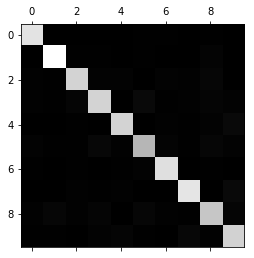

In [87]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

- 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주 대각선에 있으므로 매우 좋아 보인다.
> - 숫자 5는 다른 숫자 보다 조금 더 어두워 보인다.
>> - 배열에서 가장 큰 값은 회색, 가장 작은 값은 검은색으로 정규화 되어 그려진다.
- 이 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.
----------
- 그래프의 에러 부분에 초점을 맞춰 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다.

In [89]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums # 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교

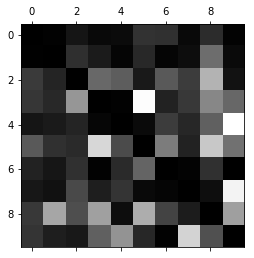

In [90]:
np.fill_diagonal(norm_conf_mx,0) # 주 대각선만 0으로 채운다.
plt.matshow(norm_conf_mx,cmap = plt.cm.gray) # 시각화
plt.show()

- 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.
> - 클래스 8과9의 열이 상당히 밝으므로 많은 이미지가 8과9로 잘못 분류되었음을 암시
> - 비슷하게 클래스 8,9의 행도 밝으므로 다른 숫자들과 혼돈이 자주 된다는 것을 말해주고 있다.
> - 반대로 클래스 1의 열은 매우 어두우므로 대부분의 숫자 1이 정확하게 분류되었음을 의미
> - 여기서 에러가 정확하게 대칭이 아니라는 점을 주목해야한다.
> - 예를들어 실제 클래스 5가 8로 잘못 분류된 갯수가 8이 5로 예측한 클래스의 갯수 보다 많다.
- 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.
- 이 그래프를 살펴보면 3과 5가 서로 혼돈되는 것을 보완하고 8과9를 더 잘 분류할 수 있도록 개선할 필요가 있다.
> - 개선 방법은 훈련 데이터를 더 모으거나, 좋은 특성들을 추가시키는 것이다.
- 개개의 에러를 분석해보면 분류기가 무슨 일을 하고 있고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있지만 더 어렵고 시간이 오래걸린다.

## 3.6 다중 레이블 분류
- 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다.
- 여러 개의 이진 레이블을 출력하는 분류 시스템을 다중 레이블 분류 시스템이라 한다.

In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
y_train_large = (y_train >= 7) # 7이상의 숫자
y_train_odd = (y_train % 2 == 1) # 홀수 숫자
y_multilabel = np.c_[y_train_large, y_train_odd] 
# 7이상의 숫자와 홀수 숫자의 데이터들을 결합 shape(train_size,2)
print(y_multilabel.shape)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

(60000, 2)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

- 결정트리,최근접분류, 랜덤포레스트, OneVsRestClassifier에서도 다중 레이블 분류를 지원

In [97]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 다중 레이블 분류기의 평가 방법은 많습니다.
> - 적절한 지표는 프로젝트에 따라 다르다. 

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1.score(y_multilabel, y_train_pred, average='macro') # 모든 레이블의 가중치가 같다고 가정

- 실제로는 아닐 수 있지만 이 코드는 모든 레이블 가중치가 같다고 가정한 것이다.
> - 예를들어 앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것이다.
> - 간단한 방법은 레이블에 클래스의 지지도(support) 즉, 타깃레이블에 속한 샘플 수를 가중치로 주는 것이다.
> - 이렇게 하려면 이전 코드에서 average='weighted'로 설정하면 된다.

## 3.7 다중 출력 분류
- 다중 출력 다중 클래스 분류는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다. (즉, 값을 두 개 이상 가질 수 있다.)
- 이를 위해 이미지에서 노이즈를 제거하는 시스템을 만들어본다.
> - 노이즈가 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력 
> - 분류기의 출력이 다중 레이블(픽셀 당 한 레이블)이고 각 레이블은 여러 개의 값(0~255까지 픽셀 강도)을 가진다. 

In [ ]:
noise = rnd.randint(0,100,(len(X_train),784)) # 0 ~ 100 까지의 train_set 크기만큼 노이즈 생성
X_train_mod = X_train + noise # train_set + noise
noise = rnd.randint(0,100,(len(X_test), 784)) 
X_test_mod = X_test + noise 
y_train_mod = X_train 
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)